In [1]:
import  time
from    tqdm.notebook           import  tqdm

import  numpy                   as      np
import  matplotlib.pyplot       as      plt
from    IPython                 import  display
from    ipywidgets              import  Output

import  custom_kinetic      as  ck
from    custom_kinetic.utils            import  *
from    custom_kinetic.distribution     import  *
from    custom_kinetic.numerical        import  *
from    custom_kinetic.collision_kernel import  *

import  os

In [2]:
# Time
DELTA_T:    float       = 0.01
MIN_T:      float       = 0.0
MAX_T:      float       = DELTA_T
NUM_T:      int         = int(1 + (MAX_T - MIN_T + 0.1*DELTA_T) / DELTA_T)
ARR_T:      np.ndarray  = np.linspace(MIN_T, MAX_T, NUM_T)

# Velocity
DIMENSION:      int         = 2
RESOLUTION:     int         = 16
MAX_V:          float       = 6.0
V:              np.ndarray  = velocity_grid(
                                    DIMENSION,
                                    RESOLUTION,
                                    MAX_V,
                                )
D_VOLUME:       float       = float(np.prod(V[ones(DIMENSION)] - V[zeros(DIMENSION)]))
_V_EXTENT = [-MAX_V, MAX_V, MAX_V, -MAX_V]


# Further configurations - FFT
FFT_NORM:   str         = 'forward'
_FREQ:      np.ndarray  = fft_index(RESOLUTION)
FREQ_MIN:   int         = int(_FREQ.min())
FREQ_MAX:   int         = int(_FREQ.max())
freqs:      np.ndarray  = freq_tensor(DIMENSION, RESOLUTION)
    
# VHS model
VHS_ALPHA:      float   = DIMENSION-2
VHS_COEFF:      float   = default_vhs_coeff_test(DIMENSION)

# Metric
METRIC_ORDER:   float   = 1
def metric(pred: np.ndarray, target: np.ndarray) -> float:
    numer = np.linalg.norm((pred - target).flatten(), ord=METRIC_ORDER)
    denom = np.linalg.norm(target.flatten(), ord=METRIC_ORDER) + 1e-32
    return float(numer / denom)


# Problem type
PROBLEM_TYPE:   str = 'bkw'
PROBLEM_TYPE = PROBLEM_TYPE.lower()

## BKW solution
BKW_COEFF_EXT:  float = default_vhs_coeff_test(DIMENSION)
BKW_GAMMA:      float = 1.0

## Maxwellian distribution
MAXWELLIAN_MEAN_DENSITY:        float       = 1.0
MAXWELLIAN_MEAN_VELOCITY:       np.ndarray  = np.zeros(DIMENSION)
MAXWELLIAN_MEAN_TEMPERATURE:    float       = 1.0

## Bimodal distribution
BIMODAL_MODE1_MEAN_DENSITY:     float       = 0.5
BIMODAL_MODE1_MEAN_VELOCITY:    np.ndarray  = np.array([MAX_V/6, *zeros(DIMENSION-1)])
BIMODAL_MODE1_MEAN_TEMPERATURE: float       = 0.5

In [3]:
print(f"[ Initialization ]")
print(f"* Setting the initial value.")
arr_f:  np.ndarray
"""A space-homogeneous initial condition"""
if PROBLEM_TYPE == 'bkw':
    bkw_sol = bkw(
                    ARR_T, V,
                    coeff_ext   = BKW_COEFF_EXT,
                    vhs_coeff   = VHS_COEFF,
                )
    arr_f = bkw_sol[0]
elif PROBLEM_TYPE == 'maxwellian':
    arr_f = maxwellian_homogeneous(
                V,
                MAXWELLIAN_MEAN_TEMPERATURE,
                MAXWELLIAN_MEAN_VELOCITY,
                MAXWELLIAN_MEAN_TEMPERATURE,
            )
elif PROBLEM_TYPE == 'bimodal':
    arr_f = maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                +BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            ) + \
            maxwellian_homogeneous(
                V,
                BIMODAL_MODE1_MEAN_DENSITY,
                -BIMODAL_MODE1_MEAN_VELOCITY,
                BIMODAL_MODE1_MEAN_TEMPERATURE,
            )

f_shape = arr_f.shape
f_axes_v = tuple(range(arr_f.ndim))

[ Initialization ]
* Setting the initial value.
----------[ BKW solution ]----------
* coeff_ext: 0.15915494309189535
* coeff_int: 0.125
------------------------------------


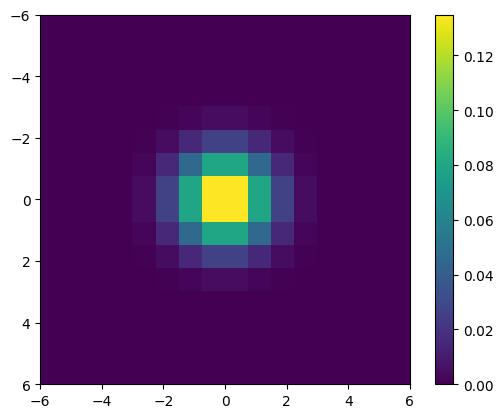

In [4]:
if DIMENSION==2:
    plt.imshow(arr_f, extent=_V_EXTENT)
    plt.colorbar()
    plt.show()

In [5]:
v_indices = velocity_index_tensor(DIMENSION, RESOLUTION)
# _dvm_scale = (2**DIMENSION) * D_VOLUME * area_of_unit_sphere(DIMENSION)
_dvm_scale = (2**DIMENSION) * D_VOLUME

def collision_operator(__PLACEHOLDER__t_curr: float, f_curr: np.ndarray) -> np.ndarray:
    ret = np.zeros(f_curr.shape)
    for vi in tqdm(v_indices):
        ret_i: np.ndarray   = 0.0
        for vj in v_indices:
            ret_ij: float   = 0.0
            N_ij:   int     = 0
            for vs in v_indices:
                for vt in v_indices:
                    # Check if the current pair of velocities is admissible
                    if not np.all(vi+vj == vs+vt):
                        continue
                    if not float(
                            ( np.sum(vi**2) + np.sum(vj**2) ) - \
                            ( np.sum(vs**2) + np.sum(vt**2) )
                        ) == 0:
                        continue
                    
                    # Update `N_ij` and `ret_ij` WITHOUT multiplying `_dvm_scale / N_ij`
                    _rel_speed = np.linalg.norm(V[tuple(vj)]-V[tuple(vi)])
                    ret_ij  += VHS_COEFF * (_rel_speed**VHS_ALPHA) * (
                        +f_curr[tuple(vs)] * f_curr[tuple(vt)] \
                        -f_curr[tuple(vi)] * f_curr[tuple(vj)]
                    )
                    N_ij    += 1
            
            # Final update of `ret_ij` and `ret_i`
            ret_ij = ret_ij * (_dvm_scale/N_ij)
            ret_i += ret_ij
        ret[tuple(vi)] = ret_i
    
    return ret

In [ ]:
print(f"[ Computation ]")
print(f"* Computing the numerical solution.")
arr_distribution        = []
arr_mean_density        = []
arr_mean_velocity       = []
arr_mean_temperature    = []
arr_rel_error           = []

out = Output()
display.display(out)

elapsed_time = time.time()

for cnt, t_curr in enumerate(tqdm(ARR_T)):
    # Backup the previous data and check if the terminal time has been reached
    arr_distribution.append(arr_f)
    
    rho, u, T = compute_moments_homogeneous(arr_f, V)
    arr_mean_density.append(rho)
    arr_mean_velocity.append(u)
    arr_mean_temperature.append(T)
    _target:    np.ndarray = None
    if PROBLEM_TYPE == 'bkw':
        _target = bkw_sol[cnt]
    elif PROBLEM_TYPE == 'maxwellian':
        _target = arr_distribution[0]
    elif PROBLEM_TYPE == 'bimodal' and _target is None:
        _target = maxwellian_homogeneous(
            V,
            arr_mean_density[0],
            arr_mean_velocity[0],
            arr_mean_temperature[0],
        )
    arr_rel_error.append( metric(arr_f, _target) )
    
    if cnt == NUM_T-1:
        break
    
    with out:
        _title = f"Relative error of order {METRIC_ORDER:.2f} by epoch {cnt} ($t={t_curr:.2f}$)\n"
        if PROBLEM_TYPE != 'bimodal':
            _title += f"Cumulative maximum error: {max(arr_rel_error):.4e}"
        else:
            _title += f"Cumulative minimum error: {min(arr_rel_error):.4e}"
        plt.plot(ARR_T[:cnt+1], arr_rel_error, 'r-', linewidth=1)
        plt.suptitle(_title)
        plt.xlim(MIN_T, MAX_T)
        plt.ylim(1e-12, 1e-0)
        plt.yscale('log')
        plt.show()
        display.clear_output(wait=True)
    
    # Update the function
    # arr_f = one_step_RK2_Heun(t_curr, arr_f, DELTA_T, collision_operator)
    arr_f = arr_f + DELTA_T * collision_operator(t_curr, arr_f)

elapsed_time = time.time() - elapsed_time


arr_distribution        = np.array(arr_distribution)
arr_mean_density        = np.array(arr_mean_density)
arr_mean_velocity       = np.array(arr_mean_velocity)
arr_mean_temperature    = np.array(arr_mean_temperature)
arr_rel_error           = np.array(arr_rel_error)
print(f"\tDone.")

[ Computation ]
* Computing the numerical solution.


Output()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

In [9]:
print(arr_rel_error[-1])

1.8590957377620523e-05


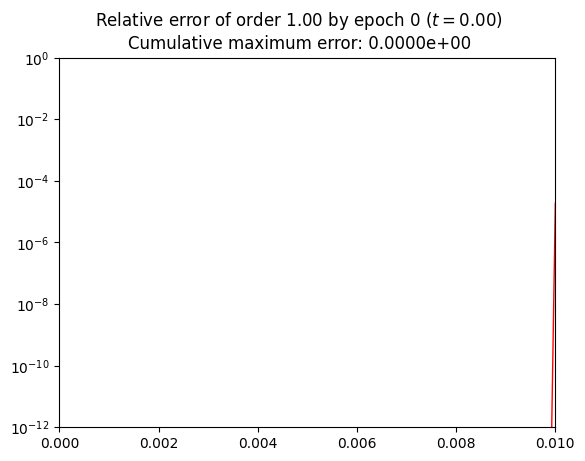

In [7]:
plt.plot(ARR_T, arr_rel_error, 'r-', linewidth=1)
plt.suptitle(_title)
plt.xlim(MIN_T, MAX_T)
plt.ylim(1e-12, 1e-0)
plt.yscale('log')
plt.show()
display.clear_output(wait=True)

In [8]:
np.savez(
    file = f"FSM_{DIMENSION}D__{PROBLEM_TYPE}_res{RESOLUTION}_L{MAX_V:.2e}_T{MAX_T}_dt{DELTA_T:.2e}",
    
    metric_order    = METRIC_ORDER,
    elapsed_time    = elapsed_time,
    
    min_t   = MIN_T,
    max_t   = MAX_T,
    delta_t = DELTA_T,
    
    dim     = DIMENSION,
    max_v   = MAX_V,
    res     = RESOLUTION,
    
    arr_distribution        = arr_distribution,
    arr_mean_density        = arr_mean_density,
    arr_mean_velocity       = arr_mean_velocity,
    arr_mean_temperature    = arr_mean_temperature,
    arr_rel_error           = arr_rel_error,
)

End of file